In [1]:
import torch
import torchaudio
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2CTCTokenizer,
)
from pydub import AudioSegment
import librosa
import numpy as np
import scipy.io.wavfile as wavfile

/mnt/45b9faff-45f3-43f2-903f-9b92a9a6338c/major-project/notebooks/workings/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "./audio_vocab.json"
UNK_TOKEN = "__UNK__"
PAD_TOKEN = "__PAD__"
WORD_DELIMITER = "|"

In [3]:
tokenizer = Wav2Vec2CTCTokenizer(
    config_path,
    unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
    word_delimiter_token=WORD_DELIMITER,
)
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)

In [4]:
print(tokenizer.tokenize("उपकारी गुणीव्यक्ति निहुरण छ निरन्तर फलेको बृक्षको हाँगो नझुकेको काहाँ छर"))

['उ', 'प', 'क', 'ा', 'र', 'ी', '|', 'ग', 'ु', 'ण', 'ी', 'व', '्', 'य', 'क', '्', 'त', 'ि', '|', 'न', 'ि', 'ह', 'ु', 'र', 'ण', '|', 'छ', '|', 'न', 'ि', 'र', 'न', '्', 'त', 'र', '|', 'फ', 'ल', 'े', 'क', 'ो', '|', 'ब', 'ृ', 'क', '्', 'ष', 'क', 'ो', '|', 'ह', 'ा', 'ँ', 'ग', 'ो', '|', 'न', 'झ', 'ु', 'क', 'े', 'क', 'ो', '|', 'क', 'ा', 'ह', 'ा', 'ँ', '|', 'छ', 'र']


In [5]:
print(tokenizer.encode("उपकारी गुणीव्यक्ति निहुरण छ निरन्तर फलेको बृक्षको हाँगो नझुकेको काहाँ छर"))

[10, 37, 17, 51, 43, 53, 2, 19, 54, 31, 53, 46, 61, 42, 17, 61, 32, 52, 2, 36, 52, 50, 54, 43, 31, 2, 23, 2, 36, 52, 43, 36, 61, 32, 43, 2, 38, 45, 57, 17, 59, 2, 39, 56, 17, 61, 48, 17, 59, 2, 50, 51, 3, 19, 59, 2, 36, 25, 54, 17, 57, 17, 59, 2, 17, 51, 50, 51, 3, 2, 23, 43]


In [6]:
print(
    tokenizer.decode(
        [
            10,
            37,
            17,
            51,
            43,
            53,
            2,
            19,
            54,
            31,
            53,
            46,
            61,
            42,
            17,
            61,
            32,
            52,
            2,
            36,
            52,
            50,
            54,
            43,
            31,
            2,
            23,
            2,
            36,
            52,
            43,
            36,
            61,
            32,
            43,
            2,
            38,
            45,
            57,
            17,
            59,
            2,
            39,
            56,
            17,
            61,
            48,
            17,
            59,
            2,
            50,
            51,
            3,
            19,
            59,
            2,
            36,
            25,
            54,
            17,
            57,
            17,
            59,
            2,
            17,
            51,
            50,
            51,
            3,
            2,
            23,
            43,
        ]
    )
)

उपकारी गुणीव्यक्ति निहुरण छ निरन्तर फलेको बृक्षको हाँगो नझुकेको काहाँ छर


In [7]:
processor = Wav2Vec2Processor(
    feature_extractor=feature_extractor, tokenizer=tokenizer
)

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def preprocess_audio(input_path, target_sr=16000):
    output_path = input_path
    if not input_path.endswith(".wav"):
        audio = AudioSegment.from_file(input_path)
        audio.export(output_path, format="wav")
        input_path = output_path

    audio, sr = librosa.load(input_path, sr=target_sr)

    noise_sample = audio[: int(0.5 * sr)]
    noise_mean = np.mean(noise_sample)
    audio_denoised = audio - noise_mean

    max_amplitude = np.max(np.abs(audio_denoised))
    if max_amplitude > 0:
        audio_normalized = audio_denoised / max_amplitude
    else:
        audio_normalized = audio_denoised

    audio_trimmed, _ = librosa.effects.trim(audio_normalized, top_db=20)

    wavfile.write(output_path, target_sr, (audio_trimmed * 32767).astype(np.int16))
    return output_path

In [9]:
file_path = "./input.wav"

In [10]:
output_file_path = preprocess_audio(file_path)
waveform, sample_rate = torchaudio.load(output_file_path)
target_sample_rate = 16000

In [11]:
waveform = waveform.squeeze().numpy()

In [12]:
waveform

array([0.00033569, 0.00024414, 0.00018311, ..., 0.00289917, 0.00167847,
       0.00024414], dtype=float32)

In [13]:
# for 1 sec -> 16000 samples
# for n sec -> 16000 * n samples
# the audio has 102400 samples, the time taken is 102400 / 16000 = 6.4 sec
waveform.shape

(102400,)

In [14]:
input_values = processor(
    waveform, sampling_rate=target_sample_rate, return_tensors="pt"
)

In [15]:
input_values['input_values'].shape

torch.Size([1, 102400])

In [16]:
input_values['attention_mask'].shape

torch.Size([1, 102400])

In [17]:
input = {key: value for key, value in input_values.items()}

In [18]:
input

{'input_values': tensor([[ 0.0005, -0.0001, -0.0006,  ...,  0.0199,  0.0107, -0.0001]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [19]:
with torch.no_grad():
    logits = model(**input).logits

In [20]:
logits

tensor([[[-2.0497e-02, -4.6728e-02, -3.5392e-02,  ...,  1.5917e-01,
          -1.0799e-01, -8.0928e-05],
         [-2.0247e-02, -5.3706e-02, -4.4307e-02,  ...,  1.5261e-01,
          -1.0893e-01, -2.5163e-03],
         [-1.9413e-02, -5.2142e-02, -4.3615e-02,  ...,  1.5206e-01,
          -1.0873e-01, -3.3125e-03],
         ...,
         [-2.0231e-02, -5.3876e-02, -4.4305e-02,  ...,  1.5147e-01,
          -1.0850e-01, -2.1393e-03],
         [-2.0536e-02, -5.3852e-02, -4.5051e-02,  ...,  1.5211e-01,
          -1.0839e-01, -2.2516e-03],
         [-2.6708e-02, -3.9950e-02, -1.6852e-02,  ...,  1.8702e-01,
          -9.4512e-02,  4.3404e-03]]])

In [21]:
torch.argmax(logits[0][2])

tensor(6)

In [22]:
len(logits[0])

319

In [23]:
predicted_ids = torch.argmax(logits, dim=-1)

In [24]:
predicted_ids

tensor([[29,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 29,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 29,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6, 29,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         29,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 29,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6, 29, 29,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6, 29, 29,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6, 29,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,

In [25]:
predicted_ids.shape

torch.Size([1, 319])

In [26]:
transcription = processor.decode(predicted_ids[0])

In [27]:
transcription

'डअडअडअडअडअडअडअडअडअडअछअडअडअडअडअडअडअड'

In [28]:
len(transcription)

35

In [29]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_assisted_decoding',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_flex_attn',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_dola_decoding',
 

In [30]:
model

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [31]:
model.xpu

<bound method Module.xpu of Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwis

In [32]:
with open("state_dict.txt", "w") as f:
    f.write(str(model.state_dict()))

In [33]:
for prarm in model.parameters():
    print(f"{prarm} and type is {prarm.dtype} and size is {prarm.size()}")

Parameter containing:
tensor([ 0.5747,  0.4976, -0.8159,  ...,  0.5527, -0.4666, -0.2227],
       requires_grad=True) and type is torch.float32 and size is torch.Size([1024])
Parameter containing:
tensor([[[-0.0301,  0.0601, -0.0824,  ...,  0.1017, -0.0714,  0.0293]],

        [[-0.0608,  0.2048, -0.3384,  ..., -0.2467,  0.1772, -0.0568]],

        [[-0.0760,  0.1932, -0.2710,  ...,  0.1458, -0.0731,  0.0205]],

        ...,

        [[ 0.0909, -0.0269, -0.0012,  ...,  0.2131, -0.2964, -0.1357]],

        [[-0.0822,  0.0698,  0.0471,  ...,  0.0196, -0.0282,  0.0362]],

        [[ 0.0054, -0.0195,  0.0404,  ...,  0.0238,  0.0038, -0.0026]]],
       requires_grad=True) and type is torch.float32 and size is torch.Size([512, 1, 10])
Parameter containing:
tensor([-0.0115, -0.0240, -0.0242, -0.0116, -0.0116, -0.0115, -0.0226, -0.0405,
        -0.0252, -0.0504, -0.0115, -0.0115, -0.0113, -0.0119, -0.0114, -0.0120,
        -0.0186, -0.0115, -0.0113, -0.0115, -0.0119, -0.0117, -0.0217, -0.0231,

In [34]:
import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns
import torchaudio

In [35]:
def load_audio(filepath, target_sr=16000):
    waveform, sr = torchaudio.load(filepath)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
    return waveform.squeeze(0), target_sr

In [36]:
def plot_waveform(waveform, sr):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.numpy())
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

In [37]:
def plot_spectrogram(waveform, sr):
    spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2()[0,:].detach().numpy(), aspect='auto', origin='lower')
    plt.title("Spectrogram")
    plt.colorbar(label="Log-Magnitude")
    plt.xlabel("Time (frames)")
    plt.ylabel("Frequency (bins)")
    plt.show()

In [38]:
def plot_weights(weights, title):
    plt.figure(figsize=(8, 6))
    # Ensure weights are 2D
    if weights.ndim == 1:
        weights = weights.reshape(-1, 1)  # Convert 1D to 2D if necessary
    sns.heatmap(weights, cmap="viridis")
    plt.title(title)
    plt.xlabel("Channels")
    plt.ylabel("Filters")
    plt.savefig(f"pretrained_{title}.png")
    plt.show()

In [39]:
def plot_attention(attention, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, cmap="coolwarm")
    plt.title(title)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.savefig(f"pretrained_{title}.png")
    plt.show()

In [40]:
audio_file = "input.wav"  # Replace with your audio file
waveform, sr = load_audio(audio_file)
input_values = processor(waveform, return_tensors="pt", sampling_rate=sr).input_values

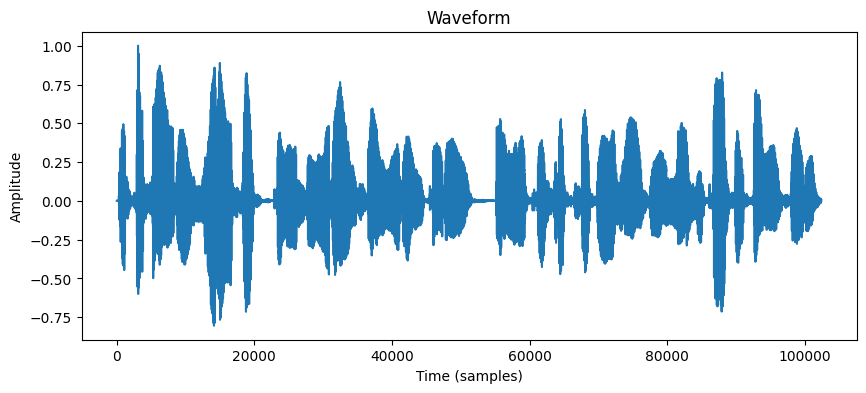

In [41]:
# Plot waveform and spectrogram
plot_waveform(waveform, sr)

In [42]:
# plot_spectrogram(waveform, sr)

In [43]:
model.wav2vec2.feature_extractor.conv_layers

ModuleList(
  (0): Wav2Vec2LayerNormConvLayer(
    (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (activation): GELUActivation()
  )
  (1-4): 4 x Wav2Vec2LayerNormConvLayer(
    (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (activation): GELUActivation()
  )
  (5-6): 2 x Wav2Vec2LayerNormConvLayer(
    (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (activation): GELUActivation()
  )
)

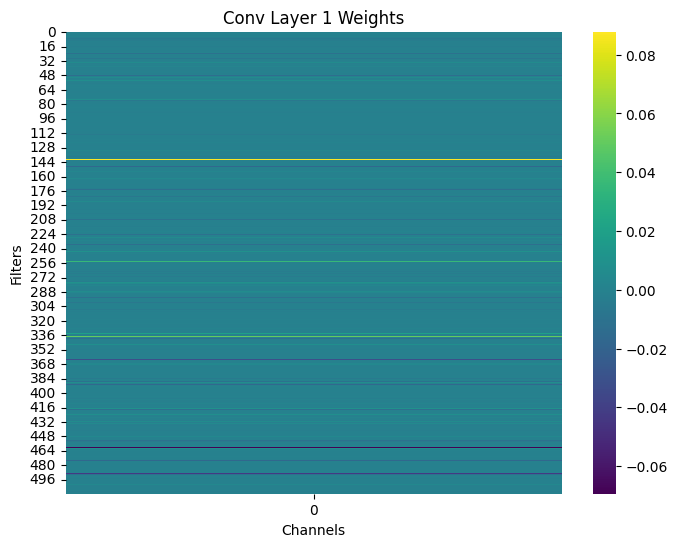

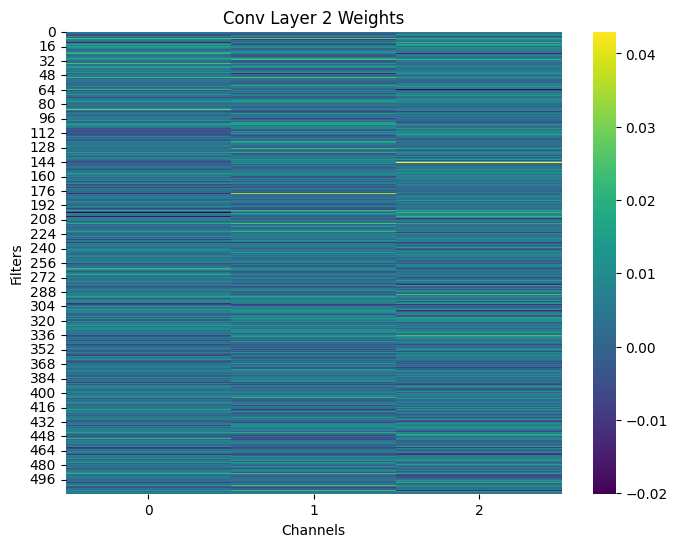

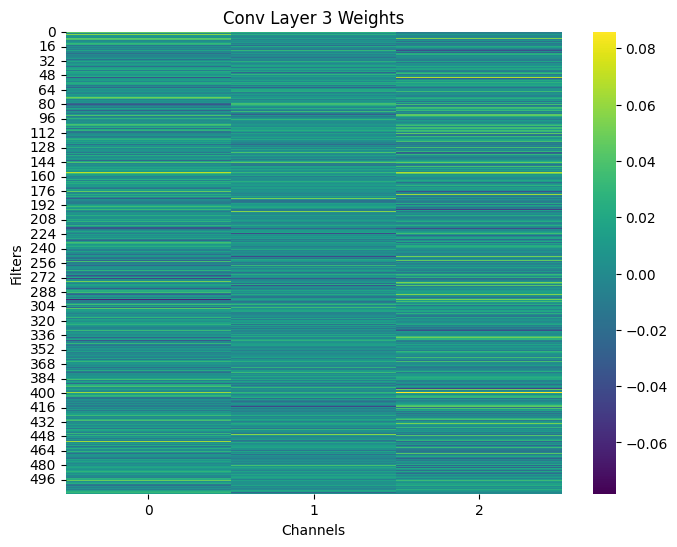

In [44]:
# Visualize convolutional layer weights
conv_layers = model.wav2vec2.feature_extractor.conv_layers
for i, layer in enumerate(conv_layers[:3]):
    weights = layer.conv.weight.data.squeeze().mean(dim=1).detach().numpy()
    plot_weights(weights, title=f"Conv Layer {i+1} Weights")

In [45]:
# Forward pass to extract features and logits
with torch.no_grad():
    outputs = model(input_values, output_hidden_states=True, output_attentions=True)
    logits = outputs.logits
    hidden_states = outputs.hidden_states
    attentions = outputs.attentions

Wav2Vec2Model is using Wav2Vec2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


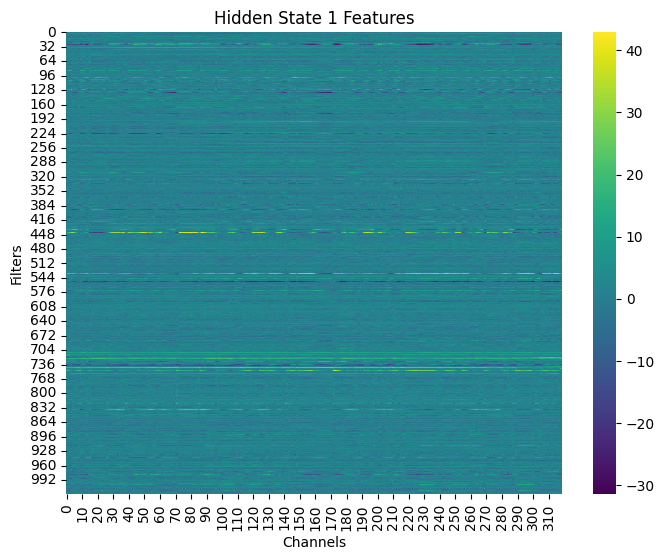

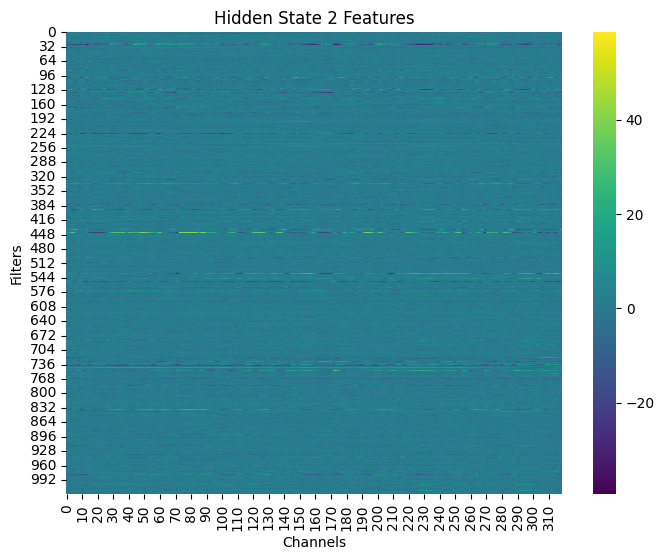

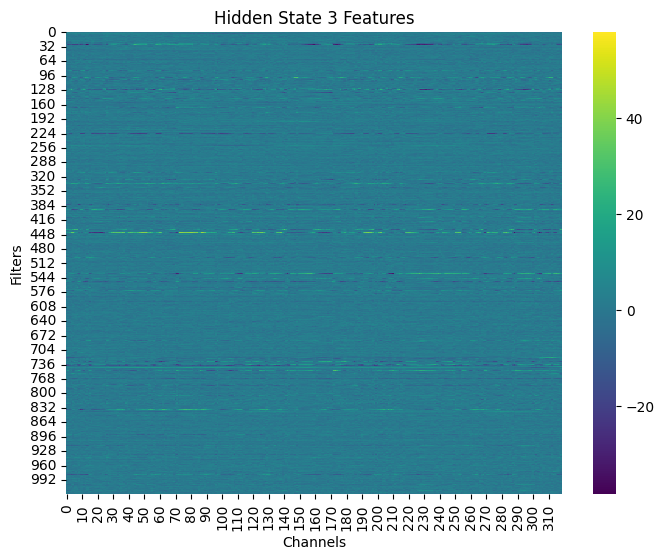

In [46]:
# Visualize feature extractor outputs
for i, hidden_state in enumerate(hidden_states[:3]):  # Show first 5 hidden states
    plot_weights(hidden_state[0].detach().numpy().T, title=f"Hidden State {i+1} Features")

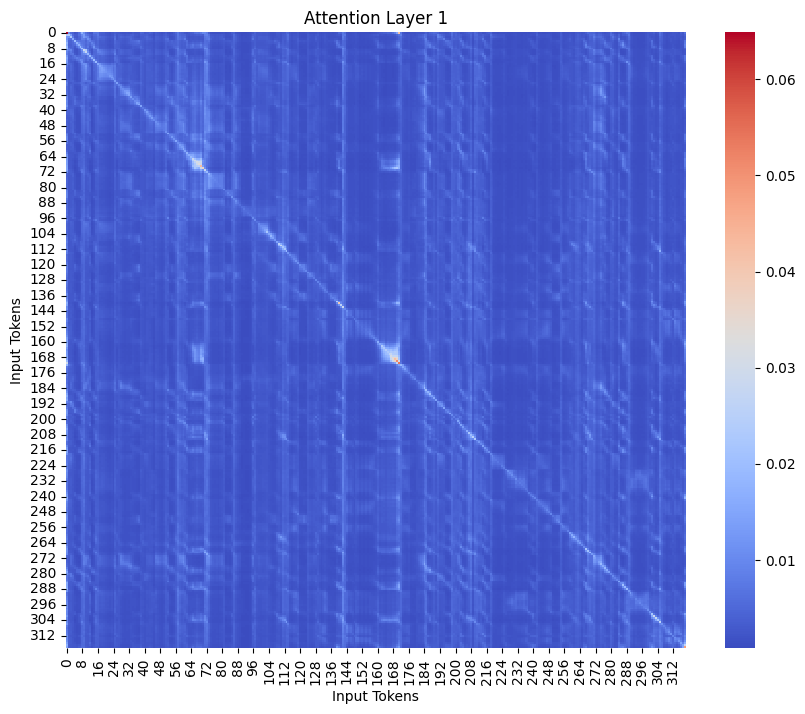

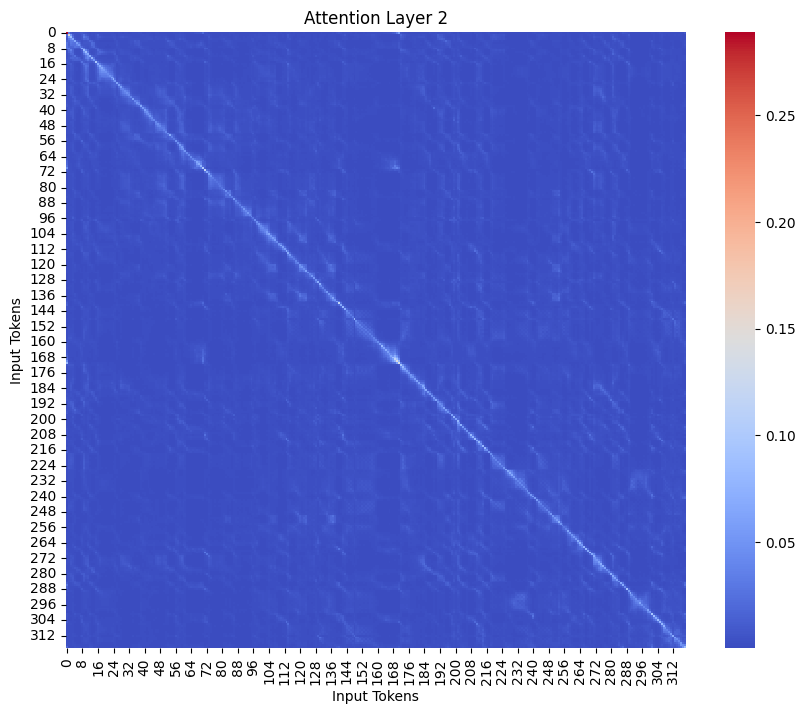

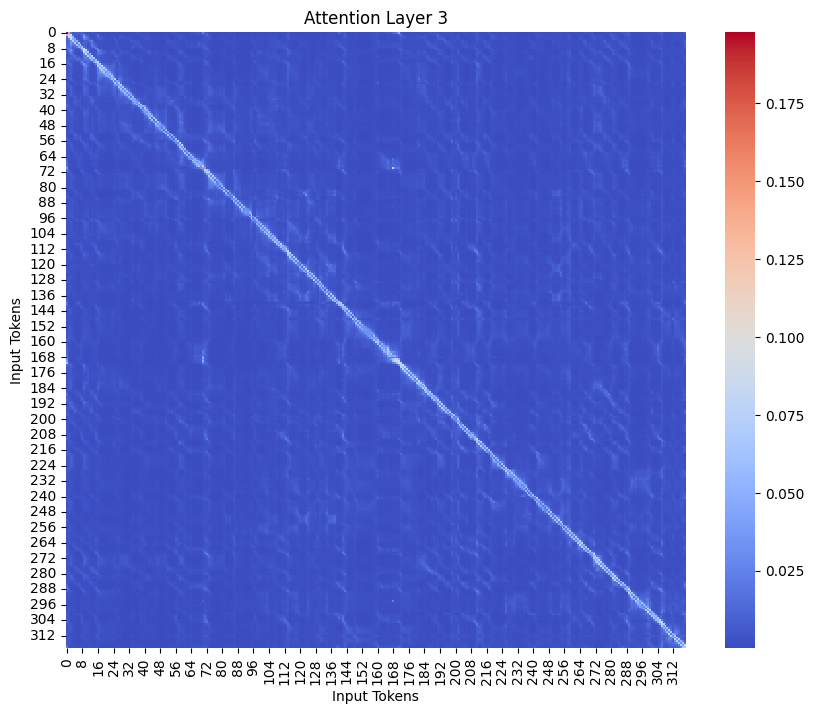

In [47]:
# Visualize attention maps (if available)
if attentions:
    for i, attention in enumerate(attentions[:3]):  # Show first 3 attention layers
        plot_attention(attention[0].mean(dim=0).detach().numpy(), title=f"Attention Layer {i+1}")

In [48]:
# Decode logits to text
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)[0]
print("Transcription:", transcription)

Transcription: डअडअडअडअडअडअडअडअडअडअछअडअडअडअडअडअडअड


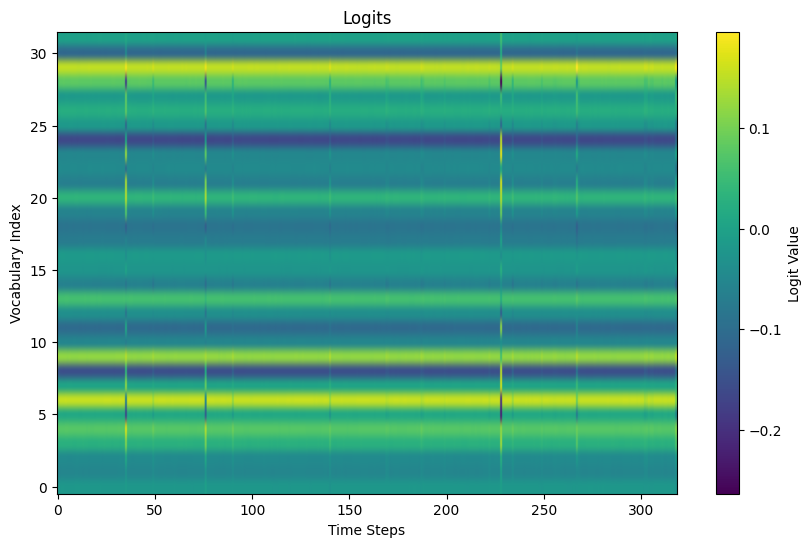

In [49]:
# Visualize logits
logits_data = logits[0].detach().numpy()
plt.figure(figsize=(10, 6))
plt.imshow(logits_data.T, aspect='auto', origin='lower', cmap="viridis")
plt.title("Logits")
plt.colorbar(label="Logit Value")
plt.xlabel("Time Steps")
plt.ylabel("Vocabulary Index")
plt.show()
